In [2]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from sklearn import model_selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier

from collections import defaultdict
from collections import Counter

from time import time

import pandas as pd
import numpy as np

import src.utilities as ut

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# from sklearn.linear_model import LogisticRegression
# from sklearn.metrics import classification_report, confusion_matrix

# Import data set:

In [4]:
pd.options.mode.chained_assignment = None


df_full = ut.import_dataset(encoding='utf-8')
df_full.head()

,text,class
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ...",Ανθρωποκτονία
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ...",Ανθρωποκτονία
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π...",Ανθρωποκτονία
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα...",Ανθρωποκτονία
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι...",Ανθρωποκτονία


# Text processing:

Kept only the column of interest leaving out the column with `class` labels.

In [7]:
df = df_full[['text']]
df['text'] = df['text'].astype('string')

df.head()

,text
0,"""Ξεκίνησε το πρωί ενώπιον των δικαστών του Μικ..."
1,"""Στο άλλο άκρο έχουν περάσει πλέον οι διαδηλώσ..."
2,"""Δεν λέει κουβέντα ο Γερμανός καταδικασμένος π..."
3,"""2,5 χρόνια μετά από τον θάνατο της Ειρήνης Λα..."
4,"""Μία εβδομάδα μετά την αρχική του εκτίμηση ότι..."


# Exploratory Data Analysis:

Let's do a little bit of EDA in these texts.

## Length of texts:

In [8]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,517.0,2584.237911,2233.321715,144.0,1336.0,1902.0,3066.0,20566.0


Visualize the results above using a boxplot:

<AxesSubplot:>

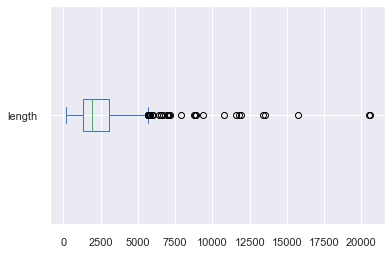

In [9]:
# Box plot:
df['length'].plot(kind='box', vert=False)